# Societies: Longevity and Causes for Collapse

An exploration of the MOROS data set on the mortality of states based on the research paper by [Scheffer et al. (2023)](https://dx.doi.org/10.1073/pnas.2218834120).
The MOROS data set covers 5,000 years of state-level societies.

The code to recreate the charts mentioned in the research is included.
What is more, a fresh analysis shows the longevity by region and lists common causes for state-level collapses.
More details and background information are available in the blog post [Reasons for the Collapse of State-Level Societies](https://ianhellstrom.org/reasons-for-societal-collapse/) from 31 December 2023.

Analysis done by [Ian Hellström](https://ianhellstrom.org) with [Zoose 4.4](https://github.com/ianhellstrom/zoose).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from thefuzz import fuzz, process

doi_prefix = "10.1073"
doi_suffix = "pnas.2218834120"
urls = [
    f"https://www.pnas.org/doi/suppl/{doi_prefix}/{doi_suffix}/suppl_file/{doi_suffix}.sd0{i}.csv"
    for i in range(1, 3)
]

In [2]:
# Stopwords to be used for extracting common causes from descriptions of state-level collapses
STOPWORDS = {
    "a",
    "about",
    "above",
    "across",
    "after",
    "afterwards",
    "again",
    "against",
    "all",
    "almost",
    "alone",
    "along",
    "already",
    "also",
    "although",
    "always",
    "am",
    "among",
    "amongst",
    "amount",
    "an",
    "and",
    "another",
    "any",
    "anyhow",
    "anyone",
    "anything",
    "anyway",
    "anywhere",
    "are",
    "around",
    "as",
    "at",
    "back",
    "be",
    "because",
    "became",
    "become",
    "becomes",
    "becoming",
    "been",
    "before",
    "beforehand",
    "behind",
    "being",
    "below",
    "beside",
    "besides",
    "between",
    "beyond",
    "both",
    "bottom",
    "but",
    "by",
    "ca",
    "call",
    "can",
    "cannot",
    "could",
    "did",
    "do",
    "does",
    "doing",
    "done",
    "down",
    "due",
    "during",
    "each",
    "eight",
    "either",
    "eleven",
    "else",
    "elsewhere",
    "empty",
    "enough",
    "even",
    "ever",
    "every",
    "everyone",
    "everything",
    "everywhere",
    "except",
    "few",
    "fifteen",
    "fifty",
    "first",
    "five",
    "for",
    "former",
    "formerly",
    "forty",
    "four",
    "from",
    "front",
    "full",
    "further",
    "get",
    "give",
    "go",
    "had",
    "has",
    "have",
    "he",
    "hence",
    "her",
    "here",
    "hereafter",
    "hereby",
    "herein",
    "hereupon",
    "hers",
    "herself",
    "him",
    "himself",
    "his",
    "how",
    "however",
    "hundred",
    "i",
    "if",
    "in",
    "indeed",
    "into",
    "is",
    "it",
    "its",
    "itself",
    "just",
    "keep",
    "last",
    "latter",
    "latterly",
    "least",
    "less",
    "made",
    "make",
    "many",
    "may",
    "me",
    "meanwhile",
    "might",
    "mine",
    "more",
    "moreover",
    "most",
    "mostly",
    "move",
    "much",
    "must",
    "my",
    "myself",
    "name",
    "namely",
    "neither",
    "never",
    "nevertheless",
    "next",
    "nine",
    "no",
    "nobody",
    "none",
    "noone",
    "nor",
    "not",
    "nothing",
    "now",
    "nowhere",
    "n‘t",
    "of",
    "off",
    "often",
    "on",
    "once",
    "one",
    "only",
    "onto",
    "or",
    "other",
    "others",
    "otherwise",
    "our",
    "ours",
    "ourselves",
    "out",
    "over",
    "own",
    "part",
    "per",
    "perhaps",
    "please",
    "put",
    "quite",
    "rather",
    "re",
    "really",
    "regarding",
    "same",
    "say",
    "see",
    "seem",
    "seemed",
    "seeming",
    "seems",
    "serious",
    "several",
    "she",
    "should",
    "show",
    "side",
    "since",
    "six",
    "sixty",
    "so",
    "some",
    "somehow",
    "someone",
    "something",
    "sometime",
    "sometimes",
    "somewhere",
    "still",
    "such",
    "take",
    "ten",
    "than",
    "that",
    "the",
    "their",
    "them",
    "themselves",
    "then",
    "thence",
    "there",
    "thereafter",
    "thereby",
    "therefore",
    "therein",
    "thereupon",
    "these",
    "they",
    "third",
    "this",
    "those",
    "though",
    "three",
    "through",
    "throughout",
    "thru",
    "thus",
    "to",
    "together",
    "too",
    "top",
    "toward",
    "towards",
    "twelve",
    "twenty",
    "two",
    "under",
    "unless",
    "until",
    "up",
    "upon",
    "us",
    "used",
    "using",
    "various",
    "very",
    "via",
    "was",
    "we",
    "well",
    "were",
    "what",
    "whatever",
    "when",
    "whence",
    "whenever",
    "where",
    "whereafter",
    "whereas",
    "whereby",
    "wherein",
    "whereupon",
    "wherever",
    "whether",
    "which",
    "while",
    "whither",
    "who",
    "whoever",
    "whole",
    "whom",
    "whose",
    "why",
    "will",
    "with",
    "within",
    "without",
    "would",
    "yet",
    "you",
    "your",
    "yours",
    "yourself",
    "yourselves",
}

Visit the PNAS URL and download the CSV file manually.
Please read the licences of the [supplementary materials](https://www.pnas.org/doi/10.1073/pnas.2218834120#supplementary-materials).
A direct download with `pd.read_csv` (with storage options) or the `requests` package (incl. headers with a user agent) do not work.

In [3]:
urls

['https://www.pnas.org/doi/suppl/10.1073/pnas.2218834120/suppl_file/pnas.2218834120.sd01.csv',
 'https://www.pnas.org/doi/suppl/10.1073/pnas.2218834120/suppl_file/pnas.2218834120.sd02.csv']

In [4]:
# Seshat and MOROS extracts from PNAS supplementary materials downloaded on 4 December 2023
seshat = f"../data/{doi_suffix}.sd01.csv"
moros = f"../data/{doi_suffix}.sd02.csv"

In [5]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

## Seshat
[Seshat](https://seshatdatabank.info/) contains the years of formation and collapse for civilizations over more than 15,000 years.
This includes many early societies from the Stone Age and beyond.

The data shared by the authors of the research paper has a mean of 326 years and a clear peak around 163 years.

In [6]:
s = pd.read_csv(seshat, encoding="latin1")

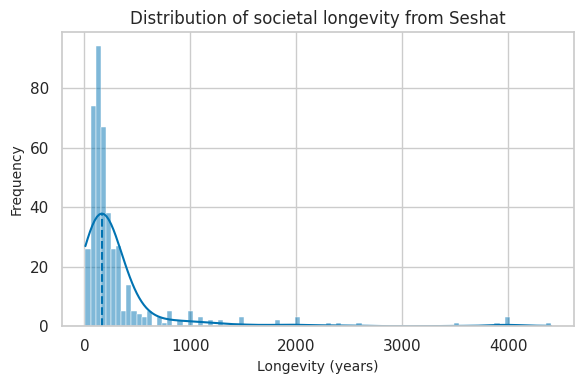

In [7]:
sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(6, 4))
ax = sns.histplot(data=s, x="age", kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
mode_idx = np.argmax(ys)
ax.vlines(xs[mode_idx], 0, ys[mode_idx], ls="--")

plt.title("Distribution of societal longevity from Seshat", fontsize=12)
plt.xlabel("Longevity (years)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)

plt.tight_layout()
plt.savefig("seshat.png", dpi=300)
plt.show()

In [8]:
round(np.mean(s["age"])), round(xs[mode_idx])

(326, 163)

## MOROS

In [9]:
mortality = pd.read_csv(moros, encoding="latin1")

In [10]:
# Sub-year resolution for formation/collapse is questionable, esp. in distant past
# Note that Python 3 relies on banker's rounding by default
mortality["formation"] = round(mortality["formation"]).astype(int)
mortality["collapse"] = round(mortality["collapse"]).astype(int)

### Clean-up
The data set contains many typos and inconsistencies that are corrected in the clean-up procedures.

In [11]:
moros_cols = [
    "Society_Polity",
    "formation",
    "collapse",
    "Peak_Power",
    "continent",
    "Region",
    "Political_Type",
    "Proximate_Cause",
    "Underlying_Cause",
    "censored",
]
moros_cols_mapped = {
    "Society_Polity": "society",
    "formation": "formed",
    "collapse": "collapsed",
    "Peak_Power": "peaked",
    "continent": "continent",
    "Region": "region",
    "Political_Type": "political_system",
    "Proximate_Cause": "collapse_cause",
    "Underlying_Cause": "collapse_subcause",
    "censored": "drop",
}

m = mortality.loc[:, moros_cols].rename(columns=moros_cols_mapped)
m["age"] = m["collapsed"] - m["formed"]

In [12]:
# Replace peaked 0.0 values with NaN if it is not between formed and collapsed
m["peaked"] = np.where(
    (m["peaked"] == 0)
    & ((m["peaked"] < m["formed"]) | (m["peaked"] >= m["collapsed"])),
    np.nan,
    m["peaked"],
)

In [13]:
# Compute the years from the peak at the time of collapse (and correct for obvious mistakes)
m["age_from_peak"] = m["collapsed"] - m["peaked"]
m["age_from_peak"] = np.where(
    (m["collapsed"] < m["peaked"]), np.nan, m["age_from_peak"]
)

In [14]:
# Combine the proximate and underlying cause in a single field
m["cause_text"] = (
    m["collapse_cause"]
    .fillna("")
    .str.cat(m["collapse_subcause"].fillna(""), sep=" ")
    .str.strip()
)

In [15]:
# Simplify the regions and standardize capitalization
def clean_region(value):
    if "/" in value:
        value = value.split("/")[0].strip()
    elif "(" in value:
        value = value.split("(")[0].strip()

    value = value.replace("N.", "North ").replace("S.", "South ")
    value = " ".join(word.capitalize() for word in value.split())

    return value


m["region"] = m["region"].apply(clean_region)

In [16]:
# Basic replacement for consistency
m["continent"].replace(
    {"S.America": "South America", "N.America": "North America"}, inplace=True
)

In [17]:
m["continent"] = m["continent"].replace("Australia", "Oceania")

# Fill in missing continents from regions
mask = m["continent"].isna()
m.loc[mask, "continent"] = m.loc[mask, "region"].str.extract(
    r"(Africa|Asia|Europe|North America|South America)", expand=False
)

# Map missing entries
continent_mapping = {
    "Polynesia": "Oceania",
    "Micronesia": "Oceania",
    "Australia And New Zealand": "Oceania",
    "Melanesia": "Oceania",
    "Central America": "North America",
}

mask = m["continent"].isna()
m.loc[mask, "continent"] = m.loc[mask, "region"].replace(continent_mapping)

### Longevity: reverse-engineering the correct filter(s)
The authors find a bump around 200 years that is not visible in the raw data without additional yet unknown processing.

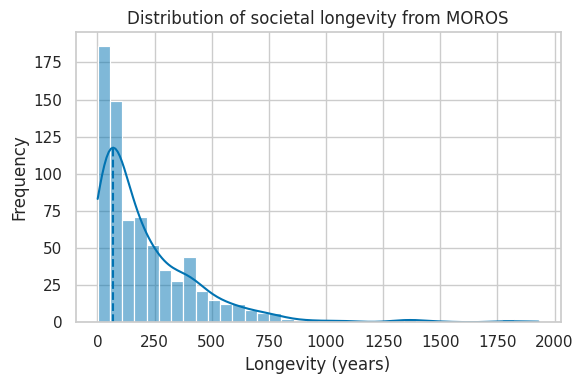

In [18]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=m, x="age", kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
mode_idx = np.argmax(ys)
ax.vlines(xs[mode_idx], 0, ys[mode_idx], ls="--")

plt.title("Distribution of societal longevity from MOROS")
plt.xlabel("Longevity (years)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("moros-unfiltered.png", dpi=300)
plt.show()

### Filtering to match the research paper's distribution
The paper has a clear peak around 200 years, which is not visible in the raw data without additional filtering.
That process is not described, so we must reverse-engineer it.

#### No cause(s)

In [19]:
# Drop all entries that do not have a cause for collapse listed
mf = m[m["cause_text"] != ""].copy()

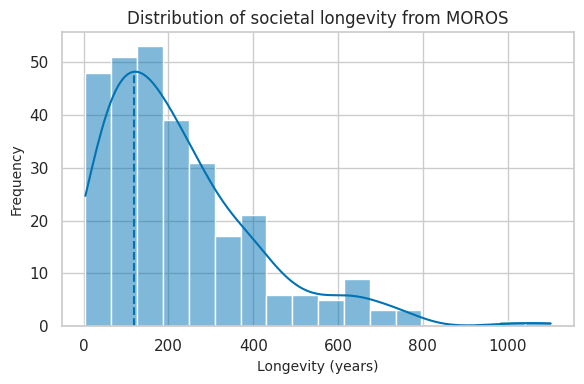

In [20]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=mf, x="age", kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
mode_idx = np.argmax(ys)
ax.vlines(xs[mode_idx], 0, ys[mode_idx], ls="--")

plt.title("Distribution of societal longevity from MOROS", fontsize=12)
plt.xlabel("Longevity (years)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)

plt.tight_layout()
plt.savefig("moros.png", dpi=300)
plt.show()

If we drop the cases without causes, the mean is 228 years and the mode 120 years.
That is pretty much what the authors find.

In [21]:
round(np.mean(mf["age"])), round(xs[mode_idx])

(228, 120)

#### Censored records
Let's try to remove everything that has a flag indicating whether the record is censored.

In [22]:
f = m[m["drop"] == False]

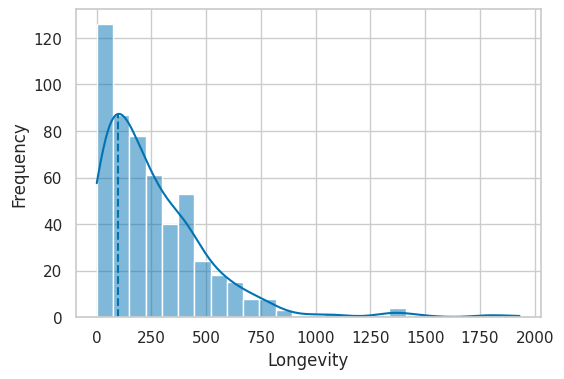

In [23]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=f, x="age", kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
mode_idx = np.argmax(ys)
ax.vlines(xs[mode_idx], 0, ys[mode_idx], ls="--")

plt.xlabel("Longevity")
plt.ylabel("Frequency")
plt.show()

If we drop the 'censored' data, the mean is 266 years with a mode at 98 years, though also no peak.
It is clear that the filtering of uncensored entries is not sufficient.

In [24]:
round(np.mean(f["age"])), round(xs[mode_idx])

(266, 98)

#### No cause(s) or censored 
Let's try a final filter: either no cause listed or censored.

In [25]:
f = m[(m["drop"] == False) | (m["cause_text"] != "")]

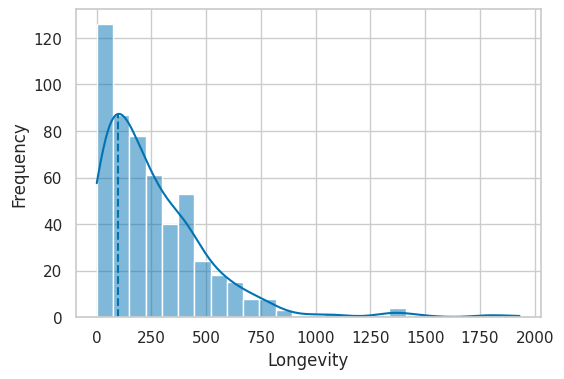

In [26]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=f, x="age", bins="auto", kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
mode_idx = np.argmax(ys)
ax.vlines(xs[mode_idx], 0, ys[mode_idx], ls="--")

plt.xlabel("Longevity")
plt.ylabel("Frequency")
plt.show()

If we drop all instances without a cause as well as censored cases, the mean is 266 years and mode 98 years. 
Again, no peak.

In [27]:
round(np.mean(f["age"])), round(xs[mode_idx])

(266, 98)

#### Conclusion: no cause(s)
**The best way to filter is therefore to remove all entries without causes.**
The data is available in the DataFrame `mf`.

### Years from peak at collapse
How long had it been from the peak of a civilization to its ultimate demise?

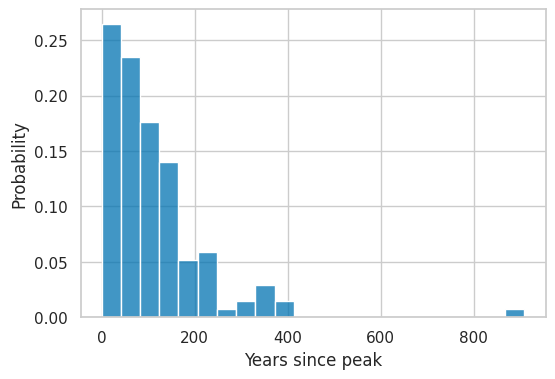

In [28]:
plt.figure(figsize=(6, 4))
sns.histplot(data=mf, x="age_from_peak", stat="probability")

plt.xlabel("Years since peak")
plt.ylabel("Probability")
plt.show()

The average age at collapse of states is 228 years with the collapse occurring 111 years after the peak of the state's power, so roughly the the middle between formation and collapse.

In [29]:
(round(np.mean(mf["age"])), round(np.mean(mf["age_from_peak"])))

(228, 111)

### Longevity by region
The authors come up with a single figure for the mortality of states that glosses over the fact that different regions appear to behave differently.

In [30]:
round(np.mean(mf["age"])), round(np.median(mf["age"]))

(228, 178)

In [31]:
average_age_by_continent = (
    mf.groupby("continent")["age"]
    .agg(["mean", "median", "count"])
    .round(1)
    .sort_values(by="median", ascending=False)
)

In [32]:
average_age_by_continent

,mean,median,count
continent,,,
South America,366.8,421.0,6
North America,332.0,284.0,4
Europe,256.7,230.0,58
Africa,240.3,200.0,61
Asia,208.7,166.0,163
Oceania,37.5,37.5,2


If we ignore the continents with few entries, we see that the highest longevity of state-level societies in the past 5,000 years in Europe, followed by Africa, and then Asia.

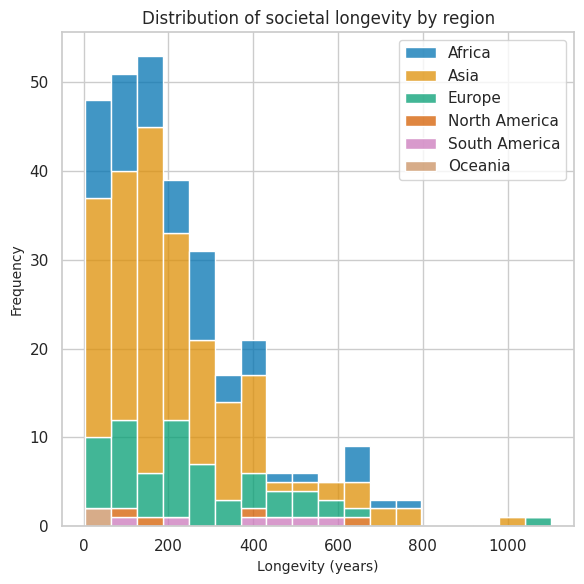

In [33]:
plt.figure(figsize=(6, 6))
ax = sns.histplot(data=mf, x="age", hue="continent", multiple="stack")

plt.title("Distribution of societal longevity by region", fontsize=12)
plt.xlabel("Longevity (years)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
ax.get_legend().set_title('')
plt.tight_layout()
plt.savefig("moros-region.png", dpi=300)
plt.show()

In [34]:
average_age_by_region = (
    mf.groupby(["continent", "region"])["age"]
    .agg(["mean", "median", "count"])
    .round(1)
    .sort_values(by=["continent", "median"], ascending=[True, False])
)
average_age_by_region

mean  median  count
continent     region                                   
Africa        Central Africa       263.0   263.0      2
              Eastern Africa       320.3   255.0     14
              Western Africa       268.6   222.0     17
              Northern Africa      207.9   176.0     21
              Western Asia          96.0    96.0      2
              Middle Africa        141.7    52.0      3
              Southern Africa       51.5    51.5      2
Asia          South-eastern Asia   320.0   295.0     21
              Southern Asia        235.3   198.0     34
              North America        177.0   177.0      2
              Western Asia         232.8   167.0     41
              Central Asia         177.2   141.0     13
              Eastern Asia         137.4   111.0     51
              Eastern Europe        82.0    82.0      1
Europe        Western Asia        1102.0  1102.0      1
              Northern Europe      247.0   273.0      3
              Southern Asia        264.0   264.0      1
              Eastern Europe       255.3   237.5     18
              Southern Europe      296.5   230.0     14
              Western Europe       205.6   200.0     19
              Western Africa        71.0    71.0      1
              Central Europe        55.0    55.0      1
North America Central America      414.0   386.0      3
              South America         86.0    86.0      1
Oceania       Polynesia             37.5    37.5      2
South America South America        366.8   421.0      6

### Longevity by political system
The following analysis is roughly the same as the one presented in the paper.
It shows that states have the highest longevity, followed by kingdoms, and regencies.

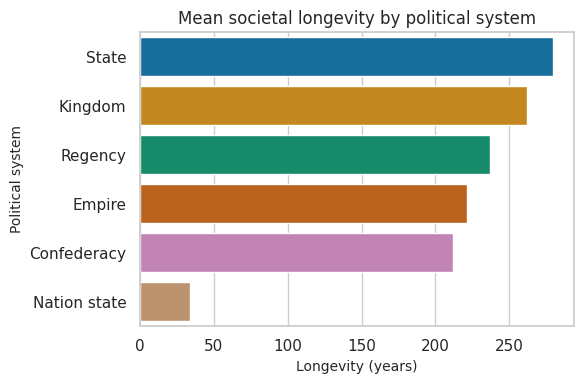

In [35]:
average_age_by_political_system = (
    mf[mf["political_system"] != "unknown"]
    .groupby("political_system")["age"]
    .mean()
    .round(1)
    .sort_values(ascending=False)
)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=average_age_by_political_system.values,
    y=average_age_by_political_system.index,
)

plt.title("Mean societal longevity by political system", fontsize=12)
plt.xlabel("Longevity (years)", fontsize=10)
plt.ylabel("Political system", fontsize=10)

plt.tight_layout()
plt.savefig("moros-system.png", dpi=300)
plt.show()

In [36]:
average_age_by_political_system

political_system
State           279.7
Kingdom         261.6
Regency         237.0
Empire          221.0
Confederacy     211.8
Nation state     34.0
Name: age, dtype: float64

### Causes for collapse
What is not described in the research paper is a breakdown of the main causes for societal collapse.
The causes are described in free-text fields lack a clear categorization.

#### Clean-up
These fields contain many typographical errors, which is why both the categorization and extraction-and-mapping procedure with fuzzy string matching is required.

The values of the `categories` dictionary below are by no means a unique mapping, but they have been inspired by the causes provided in the MOROS data set and independent research by Ian Hellström in various archaeology courses at the University of Oxford.
Details are found in the blog post mentioned in the introduction of this notebook.

In [37]:
categories = {
    "treasury": "economic",
    "mismanage": "mismanagement",
    "inequality": "inequality",
    "environment": "environment",
    "oppression": "rebellion",
    "discriminat": "inequality",
    "abandon": "transition",
    "abdicat": "transition",
    "annex": "conquest",
    "assassinat": "civil war",
    "attack": "conquest",
    "bequeathe": " transition",
    "break": "disintegration",
    "ceded": "transition",
    "civil war": "civil war",
    "climate": "climate",
    "colonis": "conquest",
    "conflict": "civil war",
    "conquered": "conquest",
    "conquest": "conquest",
    "control": "conquest",
    "coup": "coup d'état",
    "death": "disintegration",
    "decline": "disintegration",
    "defeat": "conquest",
    "deposed": "conquest",
    "destruction": "conquest",
    "died": "disintegration",
    "disease": "epidemic",
    "disintegration": "disintegration",
    "dissolution": "disintegration",
    "divide": "disintegration",
    "drought": "climate",
    "earthquake": "earthquake",
    "epidemic": "epidemic",
    "erupted": "volcanic eruption",
    "eruption": "volcanic eruption",
    "famine": "famine",
    "fell": "conquest",
    "financ": "economic",
    "flood": "climate",
    "fragmentation": "disintegration",
    "gold": "economic",
    "heir": "disintegration",
    "hunger": "famine",
    "independence": "independence",
    "invade": "conquest",
    "invasion": "conquest",
    "insurrection": "rebellion",
    "jihad": "conquest",
    "killed": "civil war",
    "lost": "conquest",
    "migration": "migration",
    "occupation": "conquest",
    "overthrow": "revolution",
    "plague": "epidemic",
    "protectorate": "transition",
    "rain": "climate",
    "rebellion": "rebellion",
    "replace": "transition",
    "resignation": "transition",
    "revolt": "rebellion",
    "revolution": "revolution",
    "sacked": "conquest",
    "seized": "conquest",
    "silver": "economic",
    "snow": "climate",
    "spend": "economic",
    "split": "disintegration",
    "strife": "civil war",
    "subject": "conquest",
    "subsume": "conquest",
    "succession": "civil war",
    "supplant": "conquest",
    "surrender": "conquest",
    "taken": "conquest",
    "tax": "economic",
    "trade": "trade",
    "trading": "trade",
    "transform": "transition",
    "transition": "transition",
    "uprising": "rebellion",
    "usurp": "conquest",
    "volcano": "volcanic eruption",
    "war": "conquest",
    "warlord": "civil war",
}

In [38]:
# Drop stop words to avoid partial matches on these (e.g. drought ~ through at 85% fuzzy score cut-off)
def drop_stopwords(description):
    words = description.split()
    filtered = [word for word in words if word not in set(STOPWORDS)]
    return " ".join(filtered)


# Extraction of causes from text: fuzzy matching because of both typos and to include variations on words
mf["causes_extracted"] = mf.apply(
    lambda row: process.extractBests(
        drop_stopwords(str(row["cause_text"]).lower()),
        list(categories.keys()),
        scorer=fuzz.partial_ratio,
        score_cutoff=85,
        limit=5,
    ),
    axis=1,
)


# Fuzzy matches also include substrings (e.g. war and civil war, war and warlord)
def clean_extracted_causes(mapped_causes):
    values = [elem[0] for elem in mapped_causes]
    if ({"civil war", "war"} <= set(values)) | ({"war", "warlord"} <= set(values)):
        # Drop war from causes if both war and civil war / warlord extracted
        return [elem for elem in list(mapped_causes) if elem[0] != "war"]
    else:
        return mapped_causes


mf["causes_extracted"] = mf.apply(
    lambda row: clean_extracted_causes(row["causes_extracted"]), axis=1
)

In [39]:
# Map extracted causes to unique set of categories
mf["causes_mapped"] = mf.apply(
    lambda row: pd.unique(
        [categories.get(item[0]) for item in row["causes_extracted"]]
    ),
    axis=1,
)

In [40]:
def extract_main_cause(mapped_causes):
    if len(mapped_causes) == 0:
        return ""
    elif len(mapped_causes) == 1:
        return mapped_causes[0]
    else:
        return "multi-causal"


# Grab the main cause from extraction and mapping
mf["main_cause"] = mf.apply(
    lambda row: extract_main_cause(row["causes_mapped"]),
    axis=1,
)

In [41]:
# Check if entries have no mapped/main causes
mf[mf["main_cause"] == ""]

,society,formed,collapsed,peaked,continent,region,political_system,collapse_cause,collapse_subcause,drop,age,age_from_peak,cause_text,causes_extracted,causes_mapped,main_cause
153,British Empire,1600,1707,NaN,Europe,Western Europe,Empire,Became the Kingdom of Great Britain with the Anglo-Scottish Act of Union of 1707,NaN,False,107,NaN,Became the Kingdom of Great Britain with the Anglo-Scottish Act of Union of 1707,[],[],


In [42]:
# Fix single entry manually
mf.loc[153, "mapped_causes"] = ["transition"]
mf.loc[153, "main_cause"] = "transition"

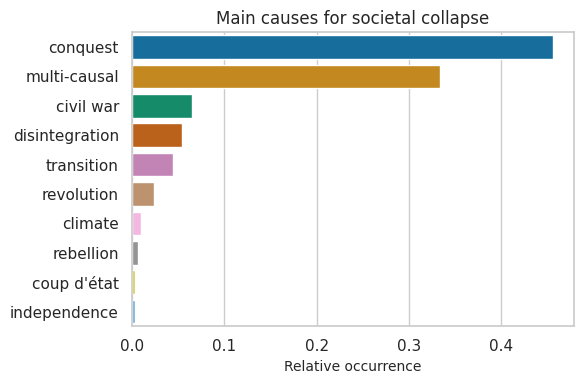

In [43]:
causes = mf.groupby("main_cause").size().sort_values(ascending=False) / len(mf)

plt.figure(figsize=(6, 4))
sns.barplot(x=causes.values, y=causes.index)

plt.title("Main causes for societal collapse", fontsize=12)
plt.xlabel("Relative occurrence", fontsize=10)
plt.ylabel("")
plt.tight_layout()
plt.savefig("moros-causes.png", dpi=300)
plt.show()

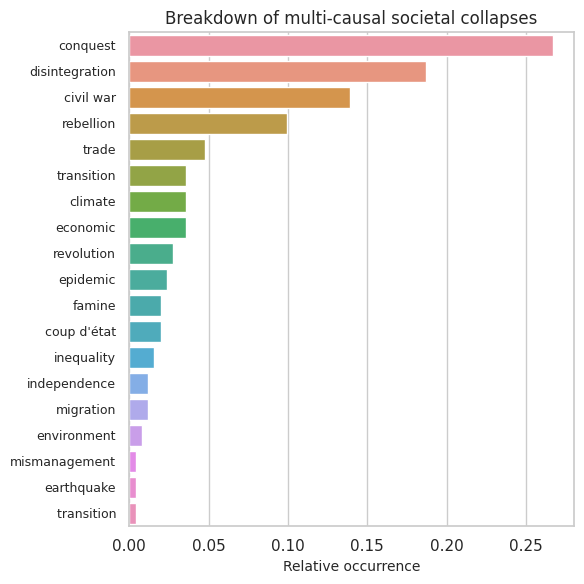

In [44]:
mfe = mf[mf["main_cause"] == "multi-causal"].explode(["causes_mapped"])

multicausal = mfe.groupby("causes_mapped").size().sort_values(ascending=False) / len(
    mfe
)

plt.figure(figsize=(6, 6))
sns.barplot(x=multicausal.values, y=multicausal.index)

plt.title("Breakdown of multi-causal societal collapses", fontsize=12)
plt.xlabel("Relative occurrence", fontsize=10)
plt.ylabel("")
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("moros-multicausal.png", dpi=300)
plt.show()

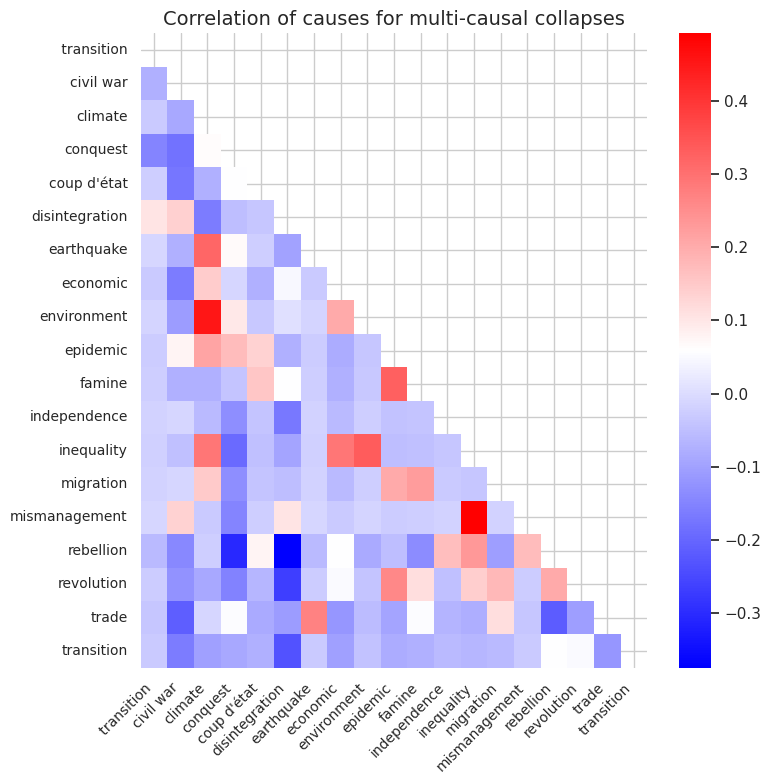

In [45]:
# Heatmap for multi-causal causes
correlations = pd.get_dummies(mfe["causes_mapped"]).groupby(level=0).sum().corr()

plt.figure(figsize=(8, 8))
mask = np.triu(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, mask=mask, cmap="bwr")
plt.title("Correlation of causes for multi-causal collapses", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("moros-multicausal-heatmap.png", dpi=300)
plt.show()

### Timeline of collapses
Let's plot the distribution of collapses over time

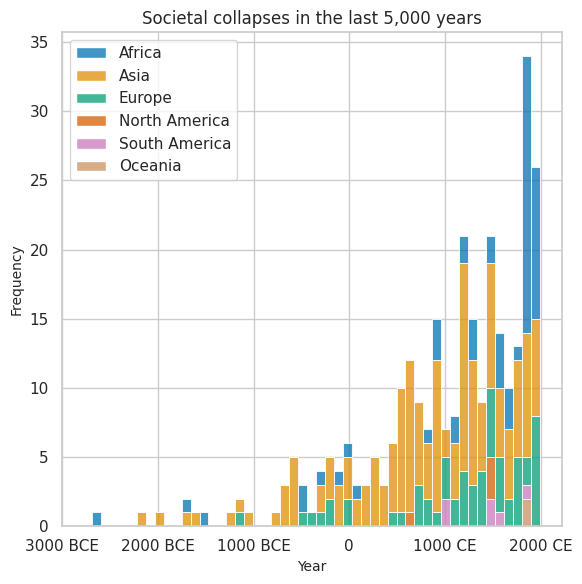

In [46]:
plt.figure(figsize=(6, 6))
ax = sns.histplot(data=mf, x="collapsed", hue="continent", multiple="stack", bins=50)

plt.title("Societal collapses in the last 5,000 years", fontsize=12)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(
    ticks=[-3000, -2000, -1000, 0, 1000, 2000],
    labels=["3000 BCE", "2000 BCE", "1000 BCE", "0", "1000 CE", "2000 CE"],
)
ax.get_legend().set_title('')
plt.tight_layout()
plt.savefig("moros-timeline.png", dpi=300)
plt.show()

---
&copy; 2023–2024 [Ian Hellström](https://ianhellstrom.org)